In [10]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://gitlab.com/secml/secml

Training of classifier complete!
Initial poisoning sample features: CArray([0.000000e+00 1.000000e+00 0.000000e+00 ... 7.262823e-04 4.004806e-04
 5.050505e-04])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 78.70%
Accuracy after attack on test set: 6.49%


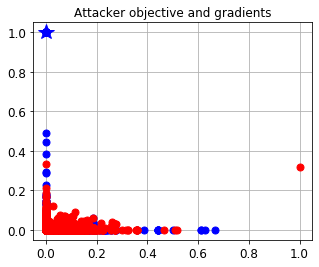

In [11]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 3000  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
# pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_logistic_adv = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



In [12]:
import pickle
with open('pois_ds_logistic_adv','wb') as file:
    pickle.dump(pois_ds_logistic_adv,file)

In [13]:
pois_ds_logistic_adv_X_array = pois_ds_logistic_adv.X.tondarray()
pois_ds_logistic_adv_y_array = pois_ds_logistic_adv.Y.tondarray()
with open('pois_ds_logistic_adv_X_array','wb') as file:
    pickle.dump(pois_ds_logistic_adv_X_array,file)
with open('pois_ds_logistic_adv_y_array','wb') as file:
    pickle.dump(pois_ds_logistic_adv_y_array,file)

Training of classifier complete!
Initial poisoning sample features: CArray([0.019824 0.006303 0.223529 ... 0.002234 0.003004 0.076533])
Initial poisoning sample label: 1
Attack started...
Attack complete!
Original accuracy on test set: 77.87%
Accuracy after attack on test set: 91.35%


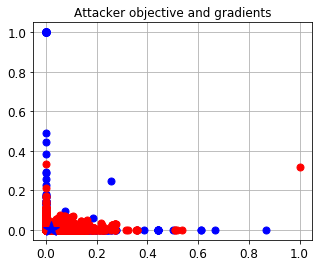

In [3]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 450  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
# pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_logistic_15 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.256863 ... 0.001171 0.001101 0.006313])
Initial poisoning sample label: 1
Attack started...
Attack complete!
Original accuracy on test set: 78.54%
Accuracy after attack on test set: 96.34%


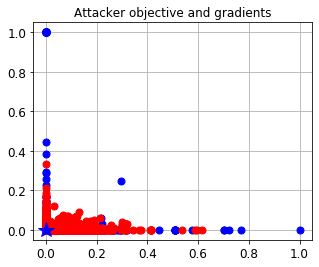

In [4]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 600  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
# pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_logistic_20 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.       ... 0.       0.       0.000398])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 77.20%
Accuracy after attack on test set: 91.51%


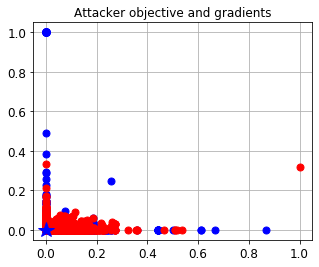

In [5]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 750  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
# pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_logistic_25 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.       ... 0.00121  0.001816 0.000655])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 78.37%
Accuracy after attack on test set: 33.94%


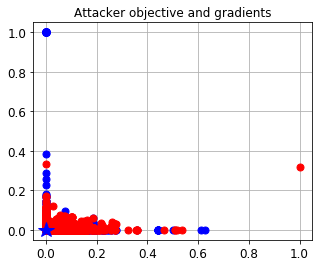

In [6]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 900  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
# pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_logistic_30 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.       ... 0.       0.       0.000596])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 78.04%
Accuracy after attack on test set: 84.03%


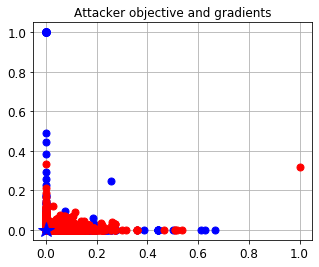

In [7]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 1050  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
# pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_logistic_35 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



Training of classifier complete!
Initial poisoning sample features: CArray([0.       0.       0.137203 ... 0.001286 0.001702 0.01143 ])
Initial poisoning sample label: 0
Attack started...
Attack complete!
Original accuracy on test set: 74.38%
Accuracy after attack on test set: 77.20%


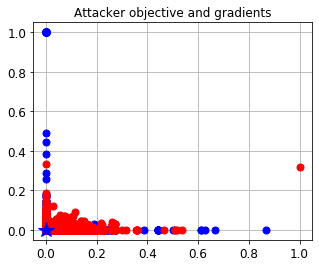

In [8]:
import pandas as pd
import numpy as np
from secml.array import CArray
from secml.data import CDataset
from sklearn.model_selection import train_test_split
from secml.ml.features import CNormalizerMinMax

#导入数据
df = pd.read_csv('./spambase/spambase.data',header=None)
random_state = 999


df_tr_val = df[:4000] #训练集+验证集
data_tr_val = df_tr_val.drop([57],axis=1)
data_array = data_tr_val.values
target_tr_val = df_tr_val[57]



df_test = df[4000:]#测试集
data_test = df_test.drop([57],axis=1)
data_test_array = data_test.values
target_test = df_test[57]
test_x = data_test_array




#训练集与验证集的划分
train_x, valid_x, train_y, valid_y = train_test_split(data_array, target_tr_val, test_size=0.25, shuffle=True)
train_y = CArray(train_y)
train_x = CArray(train_x)
valid_x = CArray(valid_x)
valid_y = CArray(valid_y)
test_x = CArray(data_test_array)
test_y = CArray(target_test)



n_tr = 3000  # Number of training set samples
n_val = 1000  # Number of validation set samples
n_ts = 601  # Number of test set samples

# Normalize the data
nmz = CNormalizerMinMax()
tr_X = nmz.fit_transform(train_x)
val_X = nmz.transform(valid_x)
ts_X = nmz.transform(test_x)




# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()


# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierRidge
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.classifiers import CClassifierRandomForest
from secml.ml.kernels import CKernelRBF
# clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)
# clf = CClassifierRidge()
clf = CClassifierLogistic()
# clf = CClassifierRandomForest()
# We can now fit the classifier
clf.fit(tr_X, train_y)
print("Training of classifier complete!")


# Compute predictions on a test set
y_pred = clf.predict(ts_X)

#设置CDataset格式
tr = CDataset(tr_X,train_y)
val = CDataset(val_X, valid_y)
ts = CDataset(ts_X, test_y)



#生成对抗样本


lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}



from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningRidge
from secml.adv.attacks import CAttackPoisoningLogisticRegression

pois_attack = CAttackPoisoningLogisticRegression(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# print(pois_attack)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc



print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))



from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')



n_poisoning_points = 1200  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
# pois_attack.init_type = 'random'
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

pois_ds_logistic_40 = pois_ds


# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))



In [9]:
import numpy as np

pois_ds_logistic_10_array = pois_ds_logistic_10.X.tondarray()
pois_ds_logistic_15_array = pois_ds_logistic_15.X.tondarray()
pois_ds_logistic_20_array = pois_ds_logistic_20.X.tondarray()
pois_ds_logistic_25_array = pois_ds_logistic_25.X.tondarray()
pois_ds_logistic_30_array = pois_ds_logistic_30.X.tondarray()
pois_ds_logistic_35_array = pois_ds_logistic_35.X.tondarray()
pois_ds_logistic_40_array = pois_ds_logistic_40.X.tondarray()

# np.savetxt('logistic_pois_ds',(pois_ds_logistic_10_array,pois_ds_logistic_15_array,pois_ds_logistic_20_array,pois_ds_logistic_25_array,pois_ds_logistic_30_array,pois_ds_logistic_35_array,pois_ds_logistic_40_array),fmt='%s')

import pickle

with open('logistic_pois_ds_10','wb') as file:
    pickle.dump(pois_ds_logistic_10_array,file)
# with open('logistic_pois_ds', 'rb') as file_1:
#     pois_ds_logistic_array = pickle.load(file_1)
# print(pois_ds_logistic_array.shape)

with open('logistic_pois_ds_15','wb') as file:
    pickle.dump(pois_ds_logistic_15_array,file)
    
with open('logistic_pois_ds_20','wb') as file:
    pickle.dump(pois_ds_logistic_20_array,file)
    
with open('logistic_pois_ds_25','wb') as file:
    pickle.dump(pois_ds_logistic_25_array,file)
    
with open('logistic_pois_ds_30','wb') as file:
    pickle.dump(pois_ds_logistic_30_array,file)
    
with open('logistic_pois_ds_35','wb') as file:
    pickle.dump(pois_ds_logistic_35_array,file)

with open('logistic_pois_ds_40','wb') as file:
    pickle.dump(pois_ds_logistic_40_array,file)
    
    
pois_ds_logistic_10_array.shape

(300, 57)

In [53]:
import numpy as np

pois_ds_logistic_10_y_array = pois_ds_logistic_10.Y.tondarray()
pois_ds_logistic_15_y_array = pois_ds_logistic_15.Y.tondarray()
pois_ds_logistic_20_y_array = pois_ds_logistic_20.Y.tondarray()
pois_ds_logistic_25_y_array = pois_ds_logistic_25.Y.tondarray()
pois_ds_logistic_30_y_array = pois_ds_logistic_30.Y.tondarray()
pois_ds_logistic_35_y_array = pois_ds_logistic_35.Y.tondarray()
pois_ds_logistic_40_y_array = pois_ds_logistic_40.Y.tondarray()


with open('logistic_pois_ds_y_10','wb') as file:
    pickle.dump(pois_ds_logistic_10_y_array,file)
# with open('logistic_pois_ds', 'rb') as file_1:
#     pois_ds_logistic_array = pickle.load(file_1)
# print(pois_ds_logistic_array.shape)

with open('logistic_pois_ds_y_15','wb') as file:
    pickle.dump(pois_ds_logistic_15_y_array,file)
    
with open('logistic_pois_ds_y_20','wb') as file:
    pickle.dump(pois_ds_logistic_20_y_array,file)
    
with open('logistic_pois_ds_y_25','wb') as file:
    pickle.dump(pois_ds_logistic_25_y_array,file)
    
with open('logistic_pois_ds_y_30','wb') as file:
    pickle.dump(pois_ds_logistic_30_y_array,file)
    
with open('logistic_pois_ds_y_35','wb') as file:
    pickle.dump(pois_ds_logistic_35_y_array,file)

with open('logistic_pois_ds_y_40','wb') as file:
    pickle.dump(pois_ds_logistic_40_y_array,file)


In [70]:
import pickle
import numpy as np


with open('logistic_pois_ds_10', 'rb') as file_1:
    logistic_pois_ds_10_array = pickle.load(file_1)
# print(pois_ds_ridge_10_array.shape)

with open('logistic_pois_ds_15', 'rb') as file_1:
    logistic_pois_ds_15_array = pickle.load(file_1)
    
with open('logistic_pois_ds_20', 'rb') as file_1:
    logistic_pois_ds_20_array = pickle.load(file_1)
    
with open('logistic_pois_ds_25', 'rb') as file_1:
    logistic_pois_ds_25_array = pickle.load(file_1)
    
with open('logistic_pois_ds_30', 'rb') as file_1:
    logistic_pois_ds_30_array = pickle.load(file_1)
    
with open('logistic_pois_ds_35', 'rb') as file_1:
    logistic_pois_ds_35_array = pickle.load(file_1)
    
with open('logistic_pois_ds_40', 'rb') as file_1:
    logistic_pois_ds_40_array = pickle.load(file_1)
    
with open('logistic_pois_ds_y_10', 'rb') as file_1:
    logistic_pois_ds_y_10_array = pickle.load(file_1)
# print(pois_ds_ridge_10_array.shape)

with open('logistic_pois_ds_y_15', 'rb') as file_1:
    logistic_pois_ds_y_15_array = pickle.load(file_1)
    
with open('logistic_pois_ds_y_20', 'rb') as file_1:
    logistic_pois_ds_y_20_array = pickle.load(file_1)
    
with open('logistic_pois_ds_y_25', 'rb') as file_1:
    logistic_pois_ds_y_25_array = pickle.load(file_1)
    
with open('logistic_pois_ds_y_30', 'rb') as file_1:
    logistic_pois_ds_y_30_array = pickle.load(file_1)
    
with open('logistic_pois_ds_y_35', 'rb') as file_1:
    logistic_pois_ds_y_35_array = pickle.load(file_1)
    
with open('logistic_pois_ds_y_40', 'rb') as file_1:
    logistic_pois_ds_y_40_array = pickle.load(file_1)
    
with open('ridge_tr_X', 'rb') as file_1:
    tr_X_array = pickle.load(file_1)
    
with open('ridge_tr_y', 'rb') as file_1:
    tr_y_array = pickle.load(file_1)

# tr_X_array = np.append(tr_X_array, svm_pois_ds_40_array, axis = 0)
# tr_y_array = np.append(tr_y_array, svm_pois_ds_y_40_array, axis = 0)
# tr_y_array.shape

In [100]:
# #特征选择


# #干净的样本
# tr_X_array = tr_X.tondarray()
# tr_y_array = tr.Y.tondarray()

# print(tr_X_array.shape)


# with open('ridge_tr_X','wb') as file:
#     pickle.dump(tr_X_array,file)
    
# with open('ridge_tr_y','wb') as file:
#     pickle.dump(tr_y_array,file)
    
train_x_array_list = tr_X_array.tolist()
train_y_array_list = tr_y_array.tolist()
feature_names = df.columns.values[:-1]





#对抗样本+干净样本
logistic_pois_ds_40_list = logistic_pois_ds_40_array.tolist()

train_x_array_list = train_x_array_list+logistic_pois_ds_40_list
train_y_array_list = train_y_array_list+logistic_pois_ds_y_40_array.tolist()


import heapq
from sklearn.linear_model import Ridge
import numpy as np
clf = Ridge(alpha=1.0)
clf.fit(train_x_array_list, train_y_array_list)
coef_ridge = clf.coef_
print(coef_ridge)
coef_ridge_list = coef_ridge.tolist()
max_5_feature_index_list = map(coef_ridge_list.index, heapq.nlargest(20, coef_ridge_list))
max_5_feature_index_list_number = list(max_5_feature_index_list)
selected_features_Ridge = []
for i, enum in enumerate(max_5_feature_index_list_number):
    selected_features_Ridge.append(feature_names[enum])
print(selected_features_Ridge)





[-0.06294802  0.20350372 -0.16601689  0.00689848 -0.30146128 -0.04498174
 -0.00805117 -0.08400757  0.10085568  0.01116888  0.15543355  0.08901856
  0.04323625  0.02810283  0.06063954  0.15369252  0.14113278 -0.05356777
  0.10125846  0.20768627 -0.16040701 -0.17034576  0.04941469  0.26434622
 -0.09857924 -0.05375     0.03956343  0.22112914 -0.12827222  0.11805002
  0.12977367 -0.14523839 -0.16479094 -0.051574   -0.19215439  0.10509162
 -0.26525887  0.36071326  0.11143483  0.01021596 -0.39871971  0.11022098
 -0.12121047 -0.25155836  0.97394603  0.11956008  0.10370688 -0.16407961
  0.10712694  0.12398591  0.05274646  0.24797585  0.04728378 -0.12335449
  0.27706233  0.22873183 -0.44405007]
[44, 37, 54, 23, 51, 55, 27, 19, 1, 10, 15, 16, 30, 49, 45, 29, 38, 41, 48, 35]


In [101]:
import pickle
import numpy as np


with open('svm_pois_ds_10', 'rb') as file_1:
    svm_pois_ds_10_array = pickle.load(file_1)
# print(pois_ds_ridge_10_array.shape)

with open('svm_pois_ds_15', 'rb') as file_1:
    svm_pois_ds_15_array = pickle.load(file_1)
    
with open('svm_pois_ds_20', 'rb') as file_1:
    svm_pois_ds_20_array = pickle.load(file_1)
    
with open('svm_pois_ds_25', 'rb') as file_1:
    svm_pois_ds_25_array = pickle.load(file_1)
    
with open('svm_pois_ds_30', 'rb') as file_1:
    svm_pois_ds_30_array = pickle.load(file_1)
    
with open('svm_pois_ds_35', 'rb') as file_1:
    svm_pois_ds_35_array = pickle.load(file_1)
    
with open('svm_pois_ds_40', 'rb') as file_1:
    svm_pois_ds_40_array = pickle.load(file_1)
    
with open('svm_pois_ds_y_10', 'rb') as file_1:
    svm_pois_ds_y_10_array = pickle.load(file_1)

with open('svm_pois_ds_y_15', 'rb') as file_1:
    svm_pois_ds_y_15_array = pickle.load(file_1)
    
with open('svm_pois_ds_y_20', 'rb') as file_1:
    svm_pois_ds_y_20_array = pickle.load(file_1)
    
with open('svm_pois_ds_y_25', 'rb') as file_1:
    svm_pois_ds_y_25_array = pickle.load(file_1)
    
with open('svm_pois_ds_y_30', 'rb') as file_1:
    svm_pois_ds_y_30_array = pickle.load(file_1)
    
with open('svm_pois_ds_y_35', 'rb') as file_1:
    svm_pois_ds_y_35_array = pickle.load(file_1)
    
with open('svm_pois_ds_y_40', 'rb') as file_1:
    svm_pois_ds_y_40_array = pickle.load(file_1)
    
with open('ridge_tr_X', 'rb') as file_1:
    tr_X_array = pickle.load(file_1)
    
with open('ridge_tr_y', 'rb') as file_1:
    tr_y_array = pickle.load(file_1)

# tr_X_array = np.append(tr_X_array, svm_pois_ds_40_array, axis = 0)
# tr_y_array = np.append(tr_y_array, svm_pois_ds_y_40_array, axis = 0)
# tr_y_array.shape

In [130]:
# #特征选择


# #干净的样本
# tr_X_array = tr_X.tondarray()
# tr_y_array = tr.Y.tondarray()

# print(tr_X_array.shape)


# with open('ridge_tr_X','wb') as file:
#     pickle.dump(tr_X_array,file)
    
# with open('ridge_tr_y','wb') as file:
#     pickle.dump(tr_y_array,file)
    
train_x_array_list = tr_X_array.tolist()
train_y_array_list = tr_y_array.tolist()
feature_names = df.columns.values[:-1]





#对抗样本+干净样本
svm_pois_ds_40_list = svm_pois_ds_40_array.tolist()

train_x_array_list = train_x_array_list+svm_pois_ds_40_list
train_y_array_list = train_y_array_list+svm_pois_ds_y_40_array.tolist()


import heapq
from sklearn.linear_model import Ridge
import numpy as np
clf = Ridge(alpha=1.0)
clf.fit(train_x_array_list, train_y_array_list)
coef_ridge = clf.coef_
print(coef_ridge)
coef_ridge_list = coef_ridge.tolist()
max_5_feature_index_list = map(coef_ridge_list.index, heapq.nlargest(20, coef_ridge_list))
max_5_feature_index_list_number = list(max_5_feature_index_list)
selected_features_Ridge = []
for i, enum in enumerate(max_5_feature_index_list_number):
    selected_features_Ridge.append(feature_names[enum])
print(selected_features_Ridge)





[-0.28783426 -0.01299898  0.17924415  0.41715346  0.16024415  0.33738044
  0.57914437  0.3559066   0.26990237  0.20147261  0.04434906  0.01059909
 -0.15010885  0.10575966  0.02937379  0.73191962  0.30879671  0.32305583
  0.4408222  -0.40032343  0.39773532  0.24042588  0.49754045  0.43097289
 -0.08437985 -0.01734899 -0.04218754  0.18766309  0.32424848  0.0292484
  0.60283966  0.0991932   0.03516223  0.04823    -0.12420844 -0.69006808
 -0.01053257  0.11360017  0.06597079 -0.1740391  -0.10665281 -0.0682301
 -0.2000847   0.04249582 -0.04918271  0.09009979 -0.09192433  0.32076354
 -0.08699509  0.40859224  0.30443209  0.46060253  0.27223805  0.00785729
  0.16924751 -0.17606651  0.6356686 ]
[15, 56, 30, 6, 22, 51, 18, 23, 3, 49, 20, 7, 5, 28, 17, 47, 16, 50, 52, 8]


# svm adv samples
# 10%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [15, 6, 51, 23, 52]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [15, 6, 51, 23, 52, 21, 20, 7, 56, 5]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [15, 6, 51, 23, 52, 21, 20, 7, 56, 5, 54, 9, 22, 18, 12]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [15, 6, 51, 23, 52, 21, 20, 7, 56, 5, 54, 9, 22, 18, 12, 17, 33, 8, 16, 49]

# 15%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [6, 51, 22, 19, 56]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [6, 51, 22, 19, 56, 52, 20, 5, 23, 7]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [6, 51, 22, 19, 56, 52, 20, 5, 23, 7, 4, 18, 21, 13, 8]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [6, 51, 22, 19, 56, 52, 20, 5, 23, 7, 4, 18, 21, 13, 8, 33, 17, 9, 54, 15]

# 20%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [15, 23, 6, 19, 51]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [15, 23, 6, 19, 51, 52, 37, 22, 18, 20]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [15, 23, 6, 19, 51, 52, 37, 22, 18, 20, 56, 7, 21, 14, 53]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [15, 23, 6, 19, 51, 52, 37, 22, 18, 20, 56, 7, 21, 14, 53, 4, 8, 17, 49, 54]


# 25%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [51, 6, 15, 56, 5]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [51, 6, 15, 56, 5, 7, 9, 20, 8, 22]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [51, 6, 15, 56, 5, 7, 9, 20, 8, 22, 23, 49, 18, 19, 21]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [51, 6, 15, 56, 5, 7, 9, 20, 8, 22, 23, 49, 18, 19, 21, 17, 4, 13, 30, 29]


# 30%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [34, 9, 6, 51, 15]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [34, 9, 6, 51, 15, 54, 21, 20, 8, 5]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [34, 9, 6, 51, 15, 54, 21, 20, 8, 5, 7, 22, 52, 4, 23]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [34, 9, 6, 51, 15, 54, 21, 20, 8, 5, 7, 22, 52, 4, 23, 56, 49, 53, 18, 48]

# 35%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [56, 54, 51, 50, 7]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [56, 54, 51, 50, 7, 18, 20, 28, 23, 15]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [56, 54, 51, 50, 7, 18, 20, 28, 23, 15, 49, 14, 22, 33, 4]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [56, 54, 51, 50, 7, 18, 20, 28, 23, 15, 49, 14, 22, 33, 4, 3, 6, 21, 52, 8]

# 40%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [15, 56, 30, 6, 22]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [15, 56, 30, 6, 22, 51, 18, 23, 3, 49]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [15, 56, 30, 6, 22, 51, 18, 23, 3, 49, 20, 7, 5, 28, 17]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [15, 56, 30, 6, 22, 51, 18, 23, 3, 49, 20, 7, 5, 28, 17, 47, 16, 50, 52, 8]


# logistic adv 
# 10%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [37, 12, 23, 7, 27]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [37, 12, 23, 7, 27, 20, 18, 8, 0, 16]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [37, 12, 23, 7, 27, 20, 18, 8, 0, 16, 4, 53, 3, 15, 52]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [37, 12, 23, 7, 27, 20, 18, 8, 0, 16, 4, 53, 3, 15, 52, 56, 14, 19, 32, 44]

# 15%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [9, 21, 8, 7, 15]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [9, 21, 8, 7, 15, 6, 49, 51, 41, 54]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [9, 21, 8, 7, 15, 6, 49, 51, 41, 54, 3, 14, 10, 20, 12]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [9, 21, 8, 7, 15, 6, 49, 51, 41, 54, 3, 14, 10, 20, 12, 46, 34, 17, 32, 50]

# 20%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [1, 7, 42, 56, 28]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [1, 7, 42, 56, 28, 8, 27, 22, 20, 46]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [1, 7, 42, 56, 28, 8, 27, 22, 20, 46, 14, 21, 19, 51, 41]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [1, 7, 42, 56, 28, 8, 27, 22, 20, 46, 14, 21, 19, 51, 41, 17, 12, 6, 16, 2]



# 25%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [37, 48, 7, 56, 40]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [37, 48, 7, 56, 40, 39, 20, 23, 17, 1]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [37, 48, 7, 56, 40, 39, 20, 23, 17, 1, 33, 43, 27, 49, 11]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [37, 48, 7, 56, 40, 39, 20, 23, 17, 1, 33, 43, 27, 49, 11, 6, 50, 52, 15, 31]


# 30%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [7, 1, 56, 43, 23]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [7, 1, 56, 43, 23, 21, 8, 28, 51, 37]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [7, 1, 56, 43, 23, 21, 8, 28, 51, 37, 48, 25, 31, 33, 40]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [7, 1, 56, 43, 23, 21, 8, 28, 51, 37, 48, 25, 31, 33, 40, 13, 6, 17, 52, 41]

# 35%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [48, 44, 50, 46, 0]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [48, 44, 50, 46, 0, 8, 7, 37, 15, 20]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [48, 44, 50, 46, 0, 8, 7, 37, 15, 20, 52, 5, 6, 56, 49]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [48, 44, 50, 46, 0, 8, 7, 37, 15, 20, 52, 5, 6, 56, 49, 34, 14, 39, 21, 53]

# 40%投毒Ridge投毒之前/之后特征选择:
# 5 : [6, 15, 51, 56, 22] -> [44, 37, 54, 23, 51]
# 10: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18] -> [44, 37, 54, 23, 51, 55, 27, 19, 1, 10]
# 15: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17] -> [44, 37, 54, 23, 51, 55, 27, 19, 1, 10, 15, 16, 30, 49, 45]
# 20: [6, 15, 51, 56, 22, 52, 23, 21, 19, 18, 7, 5, 4, 20, 17, 3, 53, 16, 55, 54] -> [44, 37, 54, 23, 51, 55, 27, 19, 1, 10, 15, 16, 30, 49, 45, 29, 38, 41, 48, 35]
